In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
import warnings
warnings.filterwarnings('ignore')
from tkinter import *
from tkinter import messagebox, Tk, Label, Button
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

data = pd.read_csv('b.csv')
data.info()
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('time')
data = data.asfreq('H')
data = data.sort_index()
data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 10 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35050 non-null  float64
 2   generation hydro pumped storage consumption  35062 non-null  float64
 3   generation hydro run-of-river and poundage   35062 non-null  float64
 4   generation hydro water reservoir             35063 non-null  float64
 5   generation nuclear                           35063 non-null  float64
 6   generation solar                             35063 non-null  float64
 7   generation waste                             35062 non-null  float64
 8   generation wind onshore                      35063 non-null  float64
 9   total load actual                            35064 non-null  float64
dty

,generation biomass,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation solar,generation waste,generation wind onshore,total load actual
time,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,863.0,1051.0,1899.0,7096.0,49.0,196.0,6378.0,25385.0
2015-01-01 01:00:00+01:00,449.0,920.0,1009.0,1658.0,7096.0,50.0,195.0,5890.0,24382.0
2015-01-01 02:00:00+01:00,448.0,1164.0,973.0,1371.0,7099.0,50.0,196.0,5461.0,22734.0
2015-01-01 03:00:00+01:00,438.0,1503.0,949.0,779.0,7098.0,50.0,191.0,5238.0,21286.0
2015-01-01 04:00:00+01:00,428.0,1826.0,953.0,720.0,7097.0,42.0,189.0,4935.0,20264.0
...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,297.0,1.0,1135.0,4836.0,6073.0,85.0,277.0,3113.0,30653.0
2018-12-31 20:00:00+01:00,296.0,1.0,1172.0,3931.0,6074.0,33.0,280.0,3288.0,29735.0
2018-12-31 21:00:00+01:00,292.0,50.0,1148.0,2831.0,6076.0,31.0,286.0,3503.0,28071.0


In [23]:
# índice temporal completo
(data.index == pd.date_range(start=data.index.min(),
                              end=data.index.max(),
                              freq=data.index.freq)).all()

True

In [24]:
#1460 dias
entrenamiento_fin = '2017-12-31 23:59:00'
validacion_fin = '2018-7-31 23:59:00'
#3 dias NO
# 5 días 
#entrenamiento_fin = '2015-01-02 23:59:00'
#validacion_fin = '2015-01-03 23:59:00'
# 10 días 
#entrenamiento_fin = '2015-01-05 23:59:00'
#validacion_fin = '2015-01-08 23:59:00'
# 100 días 
#entrenamiento_fin = '2015-02-01 23:59:00'
#validacion_fin = '2015-03-20 23:59:00'
# 1000 días 
#entrenamiento_fin = '2016-09-01 23:59:00'
#validacion_fin = '2017-05-01 23:59:00'


data_entrenamiento = data.loc[: validacion_fin, :]
data_validacion   = data.loc[entrenamiento_fin:validacion_fin, :]
data_test  = data.loc[validacion_fin:, :]

print(f"Fechas train      : {data_entrenamiento.index.min()} --- {data_entrenamiento.index.max()}  (n={len(data_entrenamiento)})")
print(f"Fechas validacion : {data_validacion.index.min()} --- {data_validacion.index.max()}  (n={len(data_validacion)})")
print(f"Fechas test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Fechas train      : 2015-01-01 00:00:00+01:00 --- 2018-07-31 23:00:00+01:00  (n=31392)
Fechas validacion : 2018-01-01 00:00:00+01:00 --- 2018-07-31 23:00:00+01:00  (n=5088)
Fechas test       : 2018-08-01 00:00:00+01:00 --- 2018-12-31 23:00:00+01:00  (n=3672)


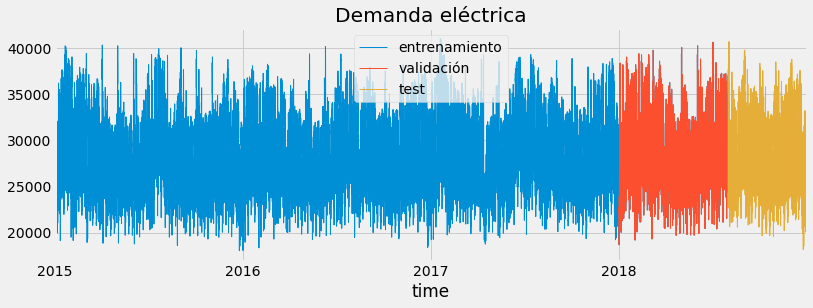

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))
data_entrenamiento['total load actual'].plot(ax=ax, label='entrenamiento', linewidth=1)
data_validacion['total load actual'].plot(ax=ax, label='validación', linewidth=1)
data_test['total load actual'].plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

In [26]:
# Creacion y entrenamiento de forecaster
forecaster = ForecasterAutoreg(
                regressor     = XGBRegressor(random_state=123),
                lags          = 24,
             )

forecaster.fit(y=data.loc[:validacion_fin, 'total load actual'])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-01-01 00:00:00+0100', tz='tzoffset(None, 3600)'), Timestamp('2018-07-31 23:00:00+0100', tz='tzoffset(None, 3600)')] 
Training index type: DatetimeIndex 
Training index 

In [27]:
# Backtesting
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data['total load actual'],
                            initial_train_size = len(data.loc[:validacion_fin]),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 31392
Number of observations used for backtesting: 3672
    Number of folds: 153
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2015-01-01 00:00:00+01:00 -- 2018-07-31 23:00:00+01:00
    Validation: 2018-08-01 00:00:00+01:00 -- 2018-08-01 23:00:00+01:00
Data partition in fold: 1
    Training:   2015-01-01 00:00:00+01:00 -- 2018-07-31 23:00:00+01:00
    Validation: 2018-08-02 00:00:00+01:00 -- 2018-08-02 23:00:00+01:00
Data partition in fold: 2
    Training:   2015-01-01 00:00:00+01:00 -- 2018-07-31 23:00:00+01:00
    Validation: 2018-08-03 00:00:00+01:00 -- 2018-08-03 23:00:00+01:00
Data partition in fold: 3
    Training:   2015-01-01 00:00:00+01:00 -- 2018-07-31 23:00:00+01:00
    Validation: 2018-08-04 00:00:00+01:00 -- 2018-08-04 23:00:00+01:00
Data partition in fold: 4
    Training:   2015-01-01 00:00:00+01:00 -- 2

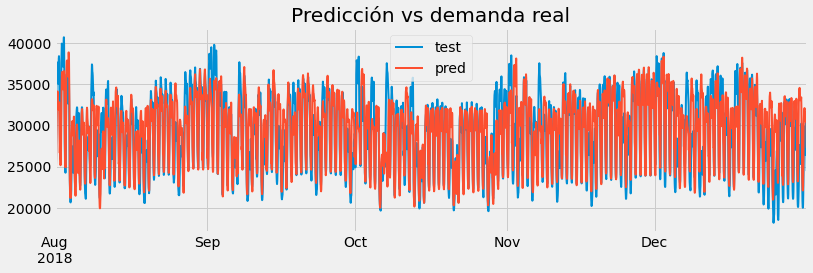

In [28]:
 # Predicción vs demanda real
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
data.loc[predicciones.index, 'total load actual'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [29]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

Error backtest: 1945.3567160479643


In [30]:
#print(f'Predicciones de 5 días: {predicciones}')

In [31]:
#Implementación distinta 

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = XGBRegressor(random_state=123),
                lags          = 24,
               
             )

# Lags utilizados como predictores
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 5, 10)}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.loc[:validacion_fin, 'total load actual'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(data[:entrenamiento_fin]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
                  )

Number of models compared: 30


loop param_grid:  50%|██████████████████▌                  | 5/10 [00:07<00:07,  1.49s/it]


In [ ]:
# Resultados Grid Search
resultados_grid

In [ ]:
forecaster

In [ ]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['total load actual'],
                            initial_train_size = len(data[:validacion_fin]),
                            fixed_train_size   = False,
                            steps              = 24,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            verbose            = False
                        )

fig, ax = plt.subplots(figsize=(12, 3.5))
data.loc[predicciones.index, 'total load actual'].plot(linewidth=1, label='Datos reales', ax=ax)
predicciones.plot(linewidth=1, label='Predicciones', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();
MAE = mean_absolute_error(data_test['total load actual'], predicciones)
print('Mean_absolute_error',MAE)


In [ ]:
metric, predicciones = backtesting_forecaster(
                            forecaster          = forecaster,
                            y                   = data['total load actual'],
                            initial_train_size  = len(data[:validacion_fin]),
                            fixed_train_size    = False,
                            steps               = 24,
                            metric              = 'mean_absolute_error',
                            interval            = [10, 90],
                            n_boot              = 500,
                            in_sample_residuals = True,
                            verbose             = False
                       )

predicciones.head(5)
d = pd.DataFrame(predicciones)
d.to_csv('sample_data.csv')

In [ ]:
# Cobertura del intervalo predicho
dentro_intervalo = np.where(
                     (data.loc[validacion_fin:, 'total load actual'] >= predicciones['lower_bound']) & \
                     (data.loc[validacion_fin:, 'total load actual'] <= predicciones['upper_bound']),
                     True,
                     False
                   )
cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {round(100*cobertura, 2)} %")